# Training on standardized data

After discussion with Hsuan-Tien and Yu-Wen, two possible solutions I can try are:
1.  Reduce the distance between the max and minimum of the spectral counts. Recommended ways are:
    -   Use the log of the spectral counts
    -   Standardize the spectral counts (Z score)
1.  Modify the loss function to be more aggresive on the high spectral counts, whcih are much rare than low councts (i.e. data imbalance). This may harmonize the model's preference on predicting moderate counts.
    -   BTW, the higher predicted spectral counts in the unmasked low value parts may be solved by including the loss of those unmasked parts. Since the mask ratio is pretty high and our observed phenomenon, counting only loss on the masked parts is not necessary.

In this notebook, I will try the first solution using log (add function to `datasets.py` and train using `test_log.py`). Then, I compare the loss and the predicted spectral counts to the models trained on the raw and standardized data.

## Functions

In [13]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from util.datasets import CustomImageDataset, log_transform
import matplotlib.pyplot as plt
import pandas as pd

def get_dataloader(batch_size: int, transform=None):
    dataset = CustomImageDataset('data/info_20231121.csv', 'data/spe', transform=transform)
    data_train, data_val = random_split(dataset, [0.8, 0.2], generator=torch.manual_seed(24))
    dataloader = {
        'train':DataLoader(data_train, batch_size=batch_size, shuffle=True),
        'val':DataLoader(data_val, batch_size=batch_size, shuffle=True)
        }
    return dataloader

def eval(model, spe_arr):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(24)
        spe = torch.from_numpy(spe_arr)
        return model(spe.unsqueeze(0).float())
    
def unpatchify(mask, pred, model):
    pred_un = model.unpatchify(pred)
    pred_un_arr = pred_un.squeeze(0).numpy()

    mask_arr = mask.squeeze(0).numpy()
    mask_un_arr = np.array([])
    for i in mask_arr:
        mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))
    mask_un_arr = mask_un_arr.astype(int)

    return pred_un_arr, mask_un_arr

def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    channel = np.arange(1, len(spe_arr)+1)
    ax.vlines(channel, ymin=0, ymax=mask_un_arr*spe_arr.max(), color='gray', alpha=0.3, label='masked')
    ax.plot(channel, spe_arr, alpha=.8, label='raw')
    ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
    ax.set_xlim(-1, 2050)
    #ax.set_ylim(0, spe_arr.max())
    ax.set_ylabel('ln(counts)')

    ax.set_xlabel('Channel')
    ax.legend()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_loss(spe_arr, pred_un_arr, mask_un_arr):
    # 0: unmasked, 1: masked
    # spe_arr: raw spectrum array
    # pred_un_arr: unpatchfied predicted spectrum array
    # mask_un_arr: unpatchfied mask array
    print(
            'loss of the masked part ({}): {:.3f}'.format(
                mask_un_arr.sum(),
                ((pred_un_arr - spe_arr)**2 * mask_un_arr).sum() / mask_un_arr.sum()
            )
    )
    print(
            'loss of the unmasked part ({}): {:.3f}'.format(
                (mask_un_arr==0).sum(),
                ((pred_un_arr - spe_arr)**2 * (mask_un_arr==0)).sum() / (mask_un_arr==0).sum()
            )
)

In [2]:
lr_df = pd.read_csv('results/test_ln_lr_20231212.csv')
lr_df

,lr,min_val_loss
0,1.000000e-03,0.119208
1,1.000000e-04,0.053017
2,1.000000e-05,0.054619
3,1.000000e-06,0.103390
4,1.000000e-07,0.490517


Text(0, 0.5, 'Minimum validation loss in 100 epochs')

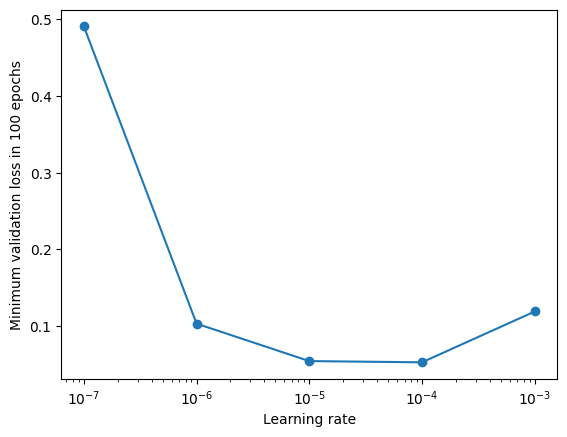

In [3]:
plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Minimum validation loss in 100 epochs')

The best learning rate is 1e-04.

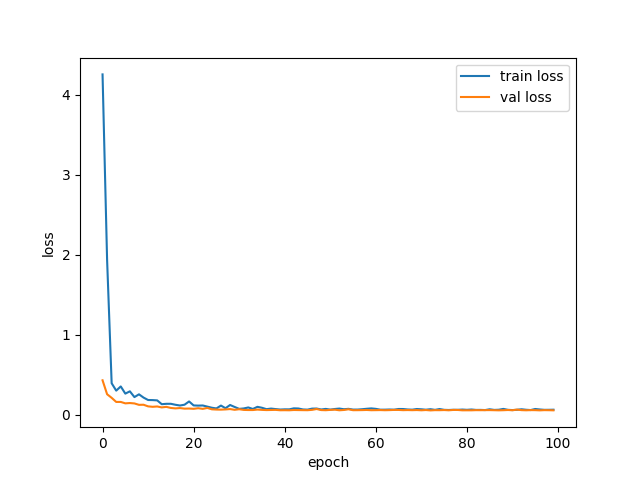

In [4]:
from IPython.display import Image
Image(filename='results/loss_ln_0.0001_20231212.png')

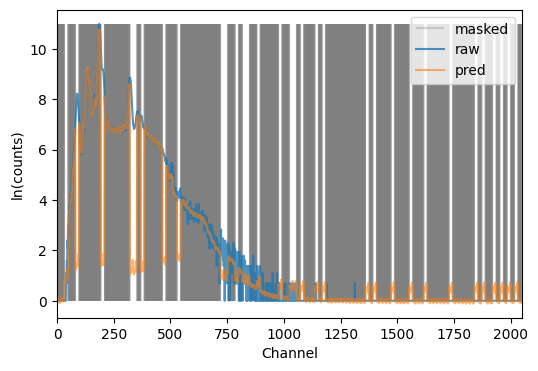

In [18]:
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_ln_0.0001_20231212.pth'))

dataloader = get_dataloader(batch_size=64, transform=log_transform)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

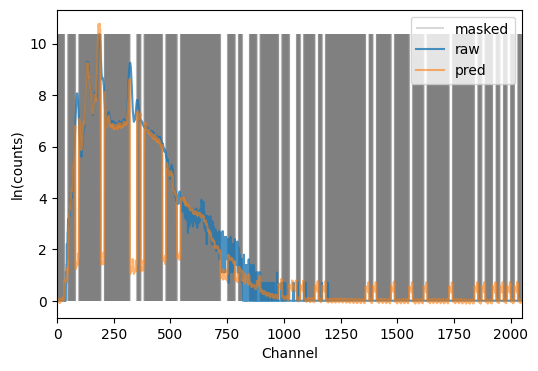

In [19]:
# inference on the validation set
spe_arr = dataloader['val'].dataset[60]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

In [20]:
print_loss(spe_arr, pred_un_arr, mask_un_arr)

loss of the masked part (1536): 0.046
loss of the unmasked part (512): 7.569


The bad performance at the unmasked parts also exisits.

## Compare the loss
In order to compare, the loss from three different models are calculated in the raw spectral counts and using a spectrum from the validation set.
### Functions

In [61]:
def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=30):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    scale = .001
    channel = np.arange(1, len(spe_arr)+1)
    for ax in axes:
        if ax == axes[0]: # normal view
            # I don't use ax.bar because it has issue on drawing at the exact positions
            # when the drawing density is too high due to the small figure size
            # this issue disappears when the figure size is large enough or zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*(spe_arr.max()*scale), color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr*scale, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr*scale, alpha=.6, label='pred')
            ax.set_xlim(-1, 2050)
            #ax.set_ylim(0, spe_arr.max()*scale)
            ax.set_ylabel('Counts (K)')
        else: # zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*ymax, color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
            
            ax.set_ylim(0, ymax)
            ax.set_ylabel('Counts')
            ax.set_xlim(-1, 2050)

        ax.set_xlabel('Channel')
        ax.legend()
    plt.show()

In [55]:
from util.datasets import standardize, log_transform

model = {}
spe_arr = {}
pred_un_arr = {}
data_list = ['raw', 'std', 'ln']
transform_list = [None, standardize, log_transform]
state_list = [
    'models/mae_vit_base_patch16_0.01_20231207.pth',
    'models/mae_vit_base_patch16_1e-05_20231211.pth',
    'models/mae_vit_base_patch16_ln_0.0001_20231212.pth'
]

for data, transform, state in zip(data_list, transform_list, state_list):
    print(data)
    # read model
    model[data] = mae_vit_base_patch16()      
    model[data].load_state_dict(torch.load(state))

    # read data
    dataloader = get_dataloader(batch_size=64, transform=transform)
    spe_arr[data] = dataloader['val'].dataset[60]

    # inference
    loss, pred, mask = eval(model[data], spe_arr[data])
    pred_un_arr[data], mask_un_arr = unpatchify(mask, pred, model[data])


raw
std
ln


In [56]:
# transform back
mean = spe_arr['raw'].mean()
std = spe_arr['raw'].std()

pred_un_arr['std'] = pred_un_arr['std'] * std + mean
pred_un_arr['ln'] = np.exp(pred_un_arr['ln'])

raw
loss of the masked part (1536): 2625933.065
loss of the unmasked part (512): 2694258.278


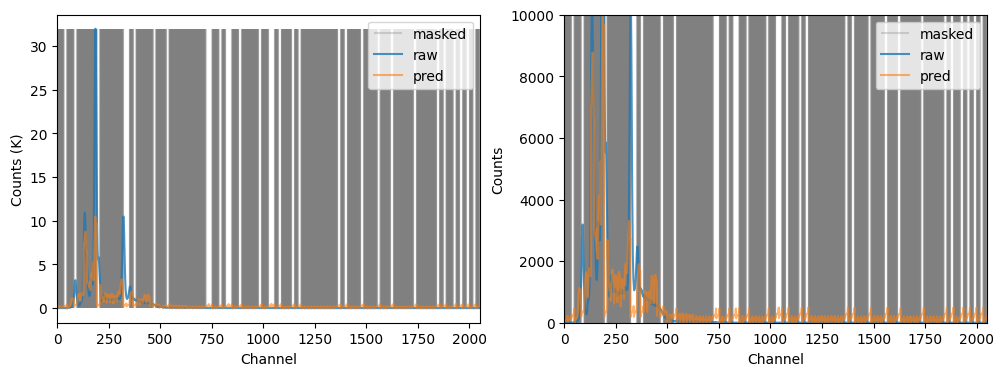

std
loss of the masked part (1536): 53531.350
loss of the unmasked part (512): 3470196.793


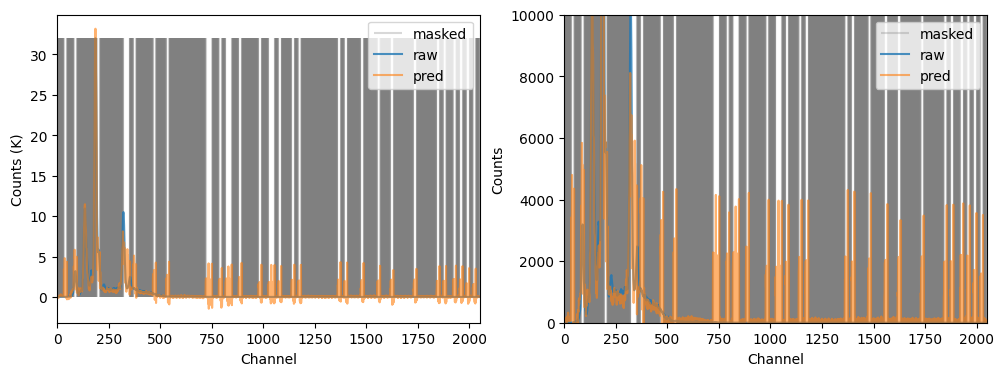

ln
loss of the masked part (1536): 2062529.071
loss of the unmasked part (512): 2938124.379


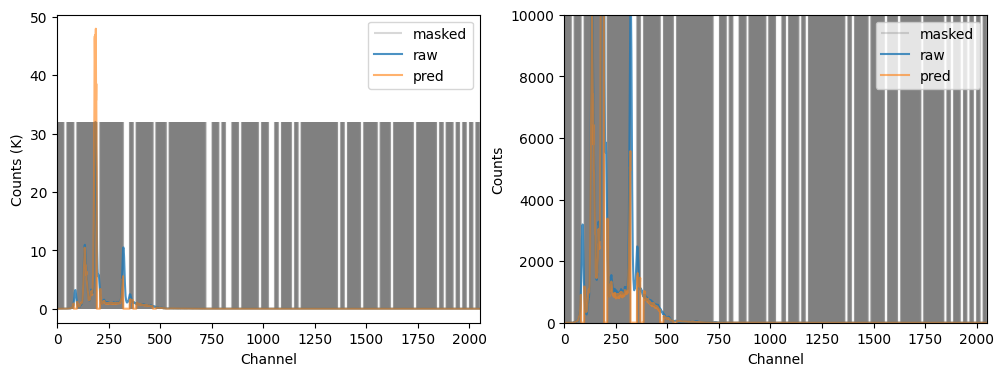

In [62]:
for data in data_list:
    print(data)
    print_loss(spe_arr['raw'], pred_un_arr[data], mask_un_arr)
    plot_spectrum(spe_arr['raw'], pred_un_arr[data], mask_un_arr, ymax=1e4)

In [65]:
print('Total loss')
print(f'No transform: {2625933.065+2694258.278}')
print(f'Standardization: {53531.350+3470196.793}')
print(f'Log transform: {2062529.071+2938124.379}')

Total loss
No transform: 5320191.343
Standardization: 3523728.143
Log transform: 5000653.45


## Discussion
I'll discuss in three perspectives:

**Total loss**: The standardization gives the best loss because it has exellent loss on the masked parts. The log transformation has slightly better loss than no transformation.

**Loss in masked/unmasked parts**: The standardization has the best loss on the masked parts, but the worst loss on the unmasked parts. It has the largest difference between the masked and unmasked parts. The log transformation has relatively smaller difference between these two parts. Mere differnece between these two parts happens in the model trained on raw data. If assuming the bad prediciton at the unmasked parts wll be constrained to be equal to the masked parts after modifying the loss function, the standardization transformation gives the best hope.

**Predicted spectral pattern**: It's a rather subjective evaluation. The incapibility of catching up very high counts in the model of no transformation is overcome more or less after transformation. The log transform predicts the best pattern, but with few extreme values. Those extreme values may be the cause of high total loss. The standardization gives very noisy pattern. The bad predictions on the masked parts is the cause.

Based on (1) the better prediction pattern, (2) the recommendation from Hsuan-Tien and Yu-Wen (reducing data skewness), and (3) the default setting of log transform in the Itrax-XRF software, I prefer to use log transforma. But I am still curious about the standardization. I want to know will the standardization give better results if I modify the loss function.